# Evaluation of fMRIPrep: comparison with FSL feat

This notebook is a supplemental material to the paper: [doi here]

### 0. Setting up

First, make sure the ``FMRIPREP_DATA_HOME`` environment variable is set and pointing to the root folder of the BIDS structure for OpenfMRI's DS000030.

In [1]:
%matplotlib inline
import os
from pathlib import Path
import warnings

import numpy as np
import nibabel as nb
import pandas as pd

from nilearn.image import concat_imgs, mean_img
from nilearn import plotting

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sn
import palettable

warnings.simplefilter('ignore')

DATA_HOME = Path(os.getenv('FMRIPREP_DATA_HOME', os.getcwd())).resolve()
DS030_HOME = DATA_HOME / 'ds000030' / '1.0.3'
DERIVS_HOME = DS030_HOME / 'derivatives'
ATLAS_HOME = DATA_HOME / 'templates' / 'mni_icbm152_nlin_asym_09c'
ANALYSIS_HOME = DERIVS_HOME / 'fmriprep_vs_feat_nosmooth'

fprep_home = DERIVS_HOME / 'fmriprep_1.0.8' / 'fmriprep'
feat_home = DERIVS_HOME / 'fslfeat_5.0.10' / 'featbids'

out_folder = Path(os.getenv('FMRIPREP_OUTPUTS') or '').resolve()

# Load MNI152 nonlinear, asymmetric 2009c atlas
atlas = nb.load(str(ATLAS_HOME / '1mm_T1.nii.gz'))
mask1mm = nb.load(str(ATLAS_HOME / '1mm_brainmask.nii.gz')).get_data() > 0
mask2mm = nb.load(str(ATLAS_HOME / '2mm_brainmask.nii.gz')).get_data() > 0
data = atlas.get_data()
data[~mask1mm] = data[~mask1mm].max()
atlas = nb.Nifti1Image(data, atlas.affine, atlas.header)

In [2]:
def mean_std_map(pipe_home, meanmask, force=False, lazy=False, maskval=1000):
    pipe_std = pipe_home / 'summary_stdev.nii.gz'
    pipe_mean = pipe_home / 'summary_means.nii.gz'

    if force or not pipe_mean.is_file():
        all_mus = []
        if lazy:
            all_mus = [nb.load(str(f)) for f in pipe_home.glob(
                'sub-*/func/sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_avgpreproc.nii.gz')]
        
        if not all_mus:
            print('Generating means file')
            pipe_files = list(pipe_home.glob(
                'sub-*/func/sub-*_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'))
            all_mus = []
            for f in pipe_files:
                mean = mean_img(str(f))
                data = mean.get_data()
                sigma = np.percentile(data[meanmask], 50) / maskval
                data /= sigma
                all_mus.append(nb.Nifti1Image(data, mean.affine, mean.header))
                
        meannii = concat_imgs(all_mus, auto_resample=False)
        meannii.to_filename(str(pipe_mean))
        force = True

    if force or not pipe_std.is_file():
        print('Generating standard deviation map')
        meannii = nb.load(str(pipe_mean))
        nb.Nifti1Image(meannii.get_data().std(3), meannii.affine, meannii.header).to_filename(str(pipe_std))
        
    return pipe_mean, pipe_std

# Use the WM mask to normalize intensities of EPI means
meanmask = nb.load(str(ATLAS_HOME / '2mm_tpm_wm.nii.gz')).get_data() > 0.9

# 1. Standard deviation across subjects of each subject's BOLD average.

We normalize the BOLD averages to have the same median value within the WM mask (WM mask of the MNI template)

<Figure size 432x288 with 0 Axes>

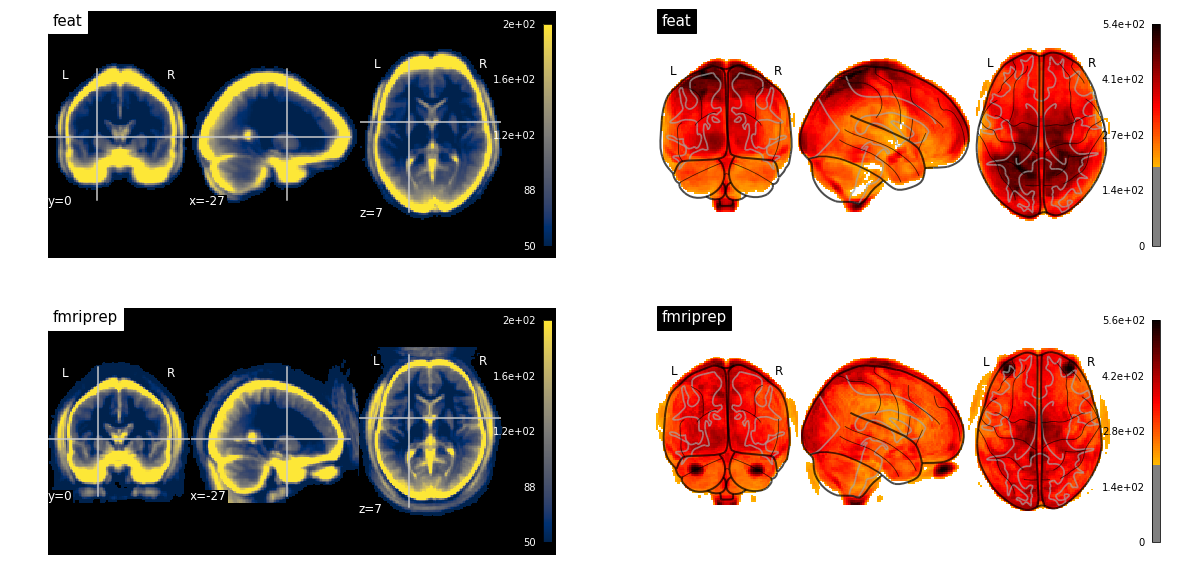

In [3]:
# Calculate average and std
fprep_mean, fprep_std = mean_std_map(fprep_home, meanmask)
feat_mean, feat_std = mean_std_map(feat_home, meanmask)

coords = [-27, 0, 7]

thres = 20
vmin = 50
vmax = 200


# Plot
plt.clf()
fig = plt.figure(figsize=(20,10))

plotting.plot_anat(str(feat_std), cut_coords=coords, colorbar=True, cmap='cividis',
                   threshold=thres, vmin=vmin, vmax=vmax, title='feat',
                   axes=plt.subplot(2,2,1)
);
plotting.plot_anat(str(fprep_std), cut_coords=coords, colorbar=True, cmap='cividis',
                   threshold=thres, vmin=vmin, vmax=vmax, title='fmriprep',
                   axes=plt.subplot(2,2,3)
);
plotting.plot_glass_brain(str(feat_std), threshold=200, colorbar=True, title='feat',
                          axes=plt.subplot(2,2,2));
plotting.plot_glass_brain(str(fprep_std), threshold=200, colorbar=True, title='fmriprep',
                          axes=plt.subplot(2,2,4));

# 2. First-level analysis

## 2.1. Inspecting one subject

In [22]:
pipelines = ['fslfeat','fmriprep']
subject = 'sub-11090'
home = {'fslfeat': feat_home, 'fmriprep': fprep_home}

Let's have a look to the z-statistic map for both pipelines

<Figure size 432x288 with 0 Axes>

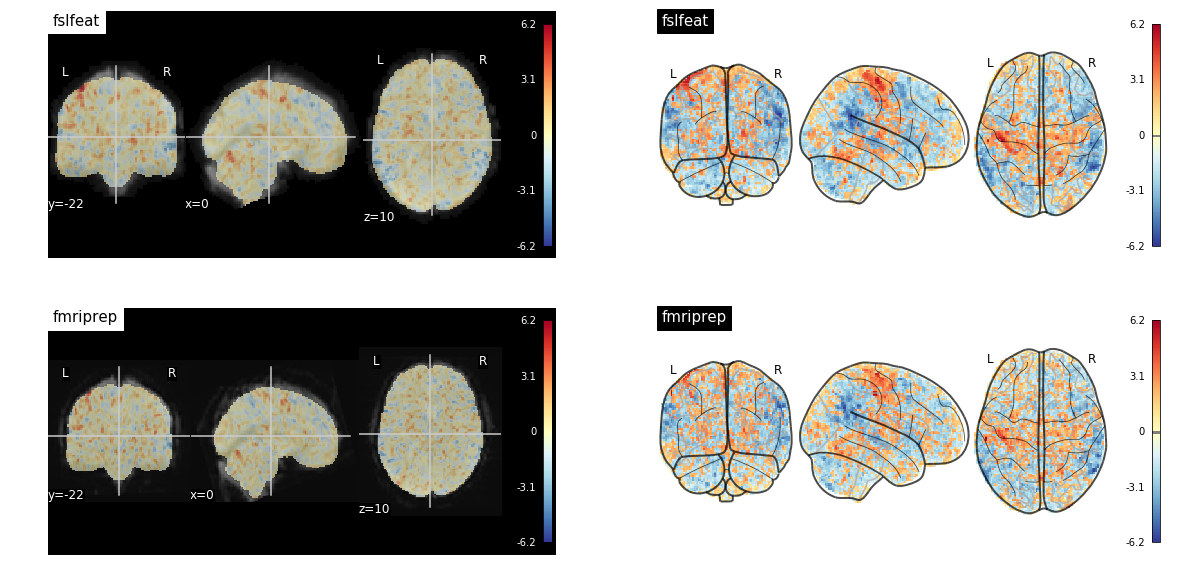

In [23]:
images = {}
bg_images = {}
preptpl = '{0}_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'.format
for pipeline in pipelines:
    z11 = ANALYSIS_HOME / subject / 'func' / '{}_task-stopsignal_variant-{}_zstat11.nii.gz'.format(subject, pipeline)
    images[pipeline] = str(z11)
    
    im = nb.load(str(home[pipeline] / subject / 'func' / preptpl(subject)))
    bg_images[pipeline] = nb.Nifti1Image(im.get_data().mean(3), im.affine, im.header)

    
# Plot
plt.clf()
fig = plt.figure(figsize=(20,10))

i = 1
for idx, pipeline in enumerate(pipelines):
    plotting.plot_stat_map(images[pipeline], title=pipeline, cmap='RdYlBu_r',
                           colorbar=True,symmetric_cbar=True, alpha=0.6,
                           bg_img=bg_images[pipeline],
                           axes=plt.subplot(2, 2, i))
    i += 1
    plotting.plot_glass_brain(images[pipeline],title=pipeline,cmap='RdYlBu_r',
                              colorbar=True,symmetric_cbar=True,plot_abs=False,
                              axes=plt.subplot(2, 2, i))
    i += 1

plotting.show();

Here we plot the distribution of z-values for this particular subject

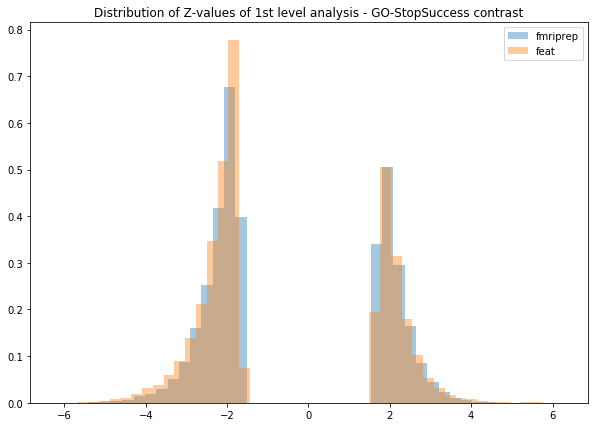

In [24]:
plt.figure(figsize=(10,7))

fprep_vals = nb.load(images['fmriprep']).get_data()[mask2mm]
feat_vals = nb.load(images['fslfeat']).get_data()[mask2mm]
sn.distplot(fprep_vals[np.abs(fprep_vals) > 1.68], label='fmriprep', kde=False, norm_hist=True)
sn.distplot(feat_vals[np.abs(feat_vals) > 1.68], label='feat', kde=False, norm_hist=True)
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

These z-values distributions correspond to the following activation maps (for this one particular subject)

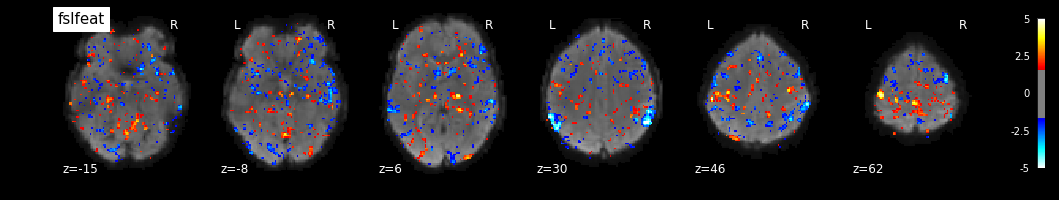

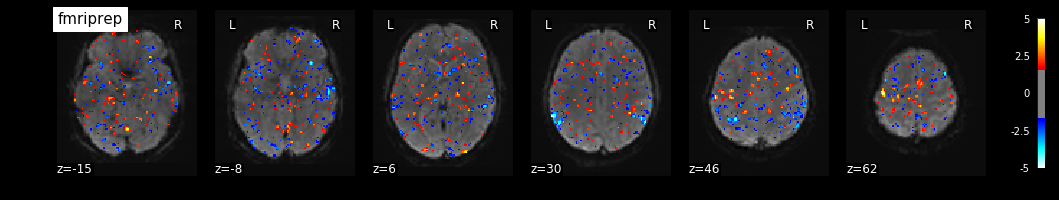

In [25]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
   plotting.plot_stat_map(images[pipeline], title=pipeline, vmax=5,
                          display_mode='z', threshold=1.65, cut_coords=cut_coords,
                          bg_img=bg_images[pipeline])
plotting.show()

## 2.2. First-level statistics aggregated

First, let's look at the aggregated distribution of Z-values and t-values resulting from the 1st level analysis. Values are masked within the MNI brain mask template.

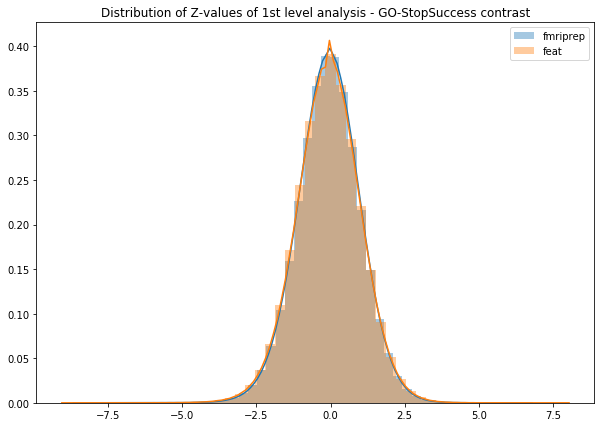

In [26]:
# Grab all Z-value maps
fmriprep_z11 = [str(f) for f in ANALYSIS_HOME.glob(
    'sub-*/func/sub-*_task-stopsignal_variant-fmriprep_zstat11.nii.gz')]
fslfeat_z11 = [str(f) for f in ANALYSIS_HOME.glob(
    'sub-*/func/sub-*_task-stopsignal_variant-fslfeat_zstat11.nii.gz')]

# Extract values
fmriprep_vals = nb.concat_images(fmriprep_z11).get_data()
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], fmriprep_vals.shape[-1], -1)
fmriprep_vals = fmriprep_vals[mask2mm4d]

feat_vals = nb.concat_images(fslfeat_z11).get_data()
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], feat_vals.shape[-1], -1)
feat_vals = feat_vals[mask2mm4d]

plt.figure(figsize=(10,7))
sn.distplot(fmriprep_vals,label='fmriprep')
sn.distplot(feat_vals,label='feat')
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

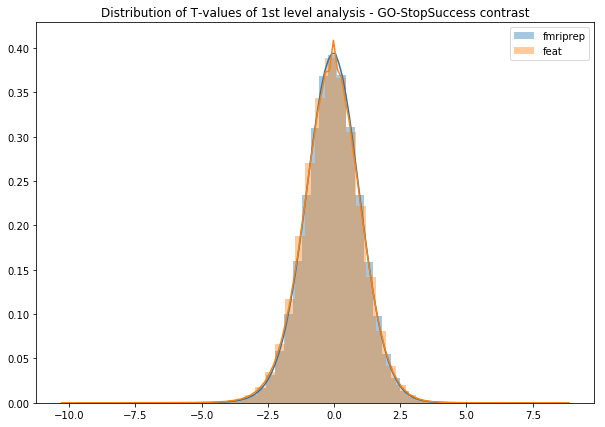

In [27]:
# Grab all T-value maps
fmriprep_t11 = [str(f) for f in ANALYSIS_HOME.glob(
    'sub-*/func/sub-*_task-stopsignal_variant-fmriprep_tstat11.nii.gz')]
fslfeat_t11 = [str(f) for f in ANALYSIS_HOME.glob(
    'sub-*/func/sub-*_task-stopsignal_variant-fslfeat_tstat11.nii.gz')]

# Extract values
fmriprep_vals = nb.concat_images(fmriprep_t11).get_data()
feat_vals = nb.concat_images(fslfeat_t11).get_data()

plt.figure(figsize=(10,7))
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], fmriprep_vals.shape[-1], -1)
sn.distplot(fmriprep_vals[mask2mm4d], label='fmriprep')
mask2mm4d = np.repeat(mask2mm[..., np.newaxis], feat_vals.shape[-1], -1)
sn.distplot(feat_vals[mask2mm4d], label='feat')
plt.title("Distribution of T-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

### Activation count maps

These distributions correspond to the following ACMs

In [18]:
from tempfile import TemporaryDirectory
from shutil import copy
from nipype.algorithms.stats import ActivationCount as ACM

cwd = os.getcwd()
with TemporaryDirectory() as tmpdirname:
    os.chdir(tmpdirname)
    acm_feat = ACM(in_files=fslfeat_z11).run().outputs.out_file
    copy(acm_feat, str(ANALYSIS_HOME / 'acm_feat.nii.gz'))
    acm_fmriprep = ACM(in_files=fmriprep_z11).run().outputs.out_file
    copy(acm_fmriprep, str(ANALYSIS_HOME / 'acm_fpre.nii.gz'))
os.chdir(cwd)

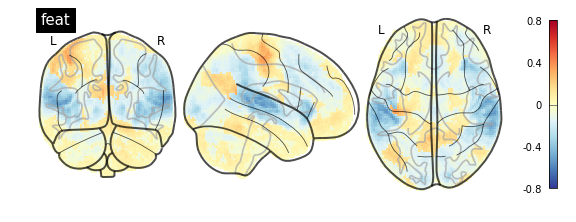

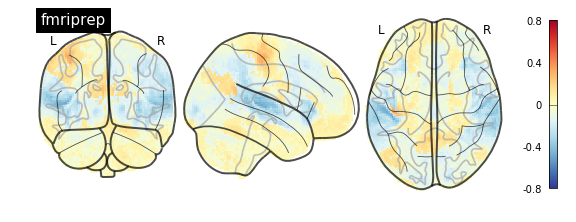

In [19]:
plotting.plot_glass_brain(str(ANALYSIS_HOME / 'acm_feat.nii.gz'), 
                          title='feat', vmin=-0.8, vmax=0.8, colorbar=True,
                          cmap='RdYlBu_r', symmetric_cbar=True, plot_abs=False)
plotting.plot_glass_brain(str(ANALYSIS_HOME / 'acm_fpre.nii.gz'), 
                          title='fmriprep', vmin=-0.8, vmax=0.8, colorbar=True,
                          cmap='RdYlBu_r', symmetric_cbar=True, plot_abs=False)
plotting.show()

<Figure size 432x288 with 0 Axes>

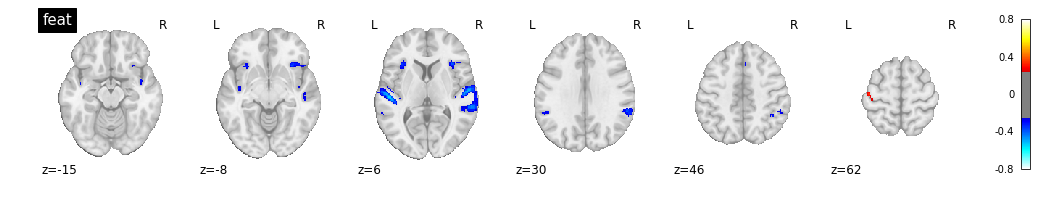

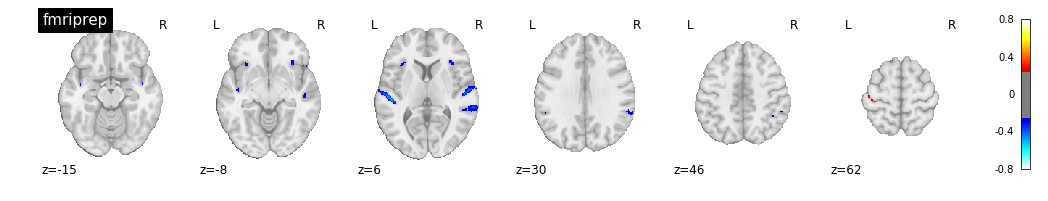

In [20]:
plt.clf()
cut_coords = [-15, -8, 6, 30, 46, 62]
plotting.plot_stat_map(str(ANALYSIS_HOME / 'acm_feat.nii.gz'),
                       title='feat', threshold=0.25, display_mode='z',
                       cut_coords=cut_coords, vmax=0.8, bg_img=atlas)

plotting.plot_stat_map(str(ANALYSIS_HOME / 'acm_fpre.nii.gz'),
                       title='fmriprep', threshold=0.25, display_mode='z',
                       cut_coords=cut_coords, vmax=0.8, bg_img=atlas)
plotting.show()

# 3. Second level analysis

## 3.1. Distribution of t-values
First, let's look at one of the random partitions of the dataset in two groups of 50 subjects, for both preprocessing options

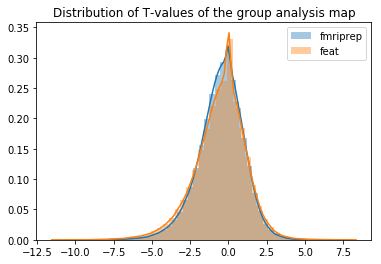

In [34]:
group_dir = ANALYSIS_HOME / 'l2-jd'

fmriprep_t = nb.load(str(group_dir / 'fmriprep_stopsignal_N050_R100_S1' / 'tstat1.nii.gz')).get_data()
feat_t = nb.load(str(group_dir / 'fslfeat_stopsignal_N050_R100_S1' / 'tstat1.nii.gz')).get_data()

sn.distplot(fmriprep_t[mask2mm],label='fmriprep')
sn.distplot(feat_t[mask2mm],label='feat')
plt.legend()
plt.title('Distribution of T-values of the group analysis map');

## 3.2. Activation map

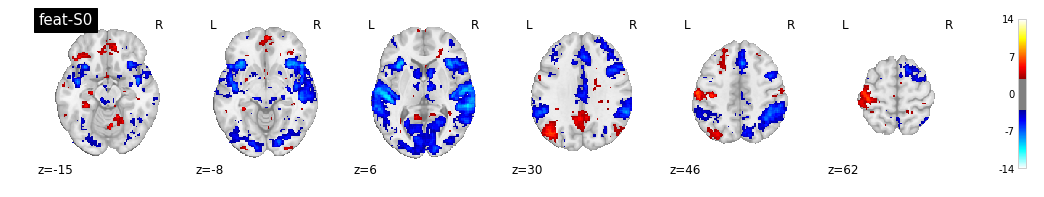

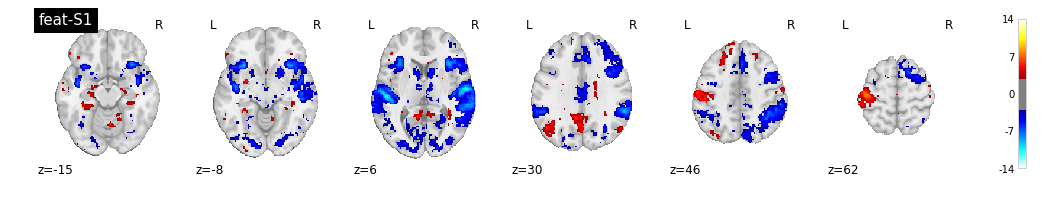

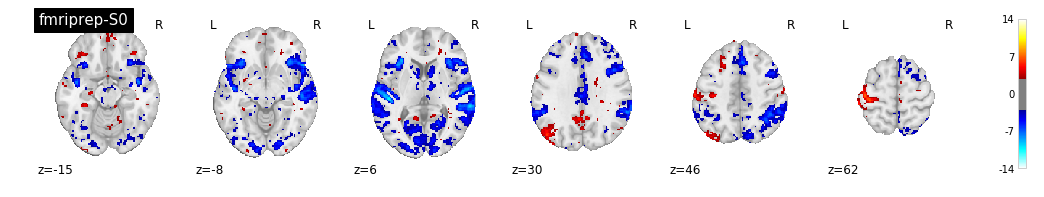

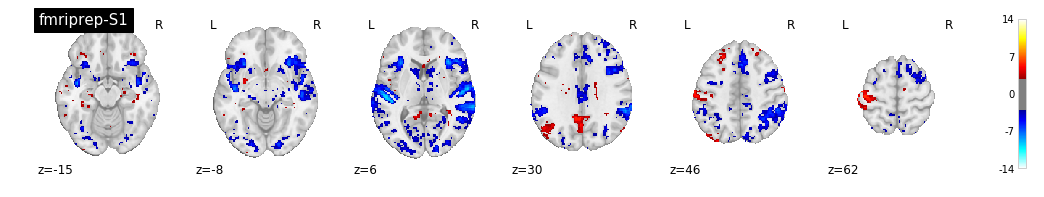

In [48]:
cut_coords = [-15, -8, 6, 30, 46, 62]
plotting.plot_stat_map(str(group_dir / 'fslfeat_stopsignal_N120_R101_S0' / 'zstat1.nii.gz'),
                       title='feat-S0', threshold=2.98, bg_img=atlas, 
                       display_mode='z', cut_coords=cut_coords, vmax=14)
plotting.plot_stat_map(str(group_dir / 'fslfeat_stopsignal_N120_R101_S1' / 'zstat1.nii.gz'),
                       title='feat-S1', threshold=2.98, bg_img=atlas,
                       display_mode='z', cut_coords=cut_coords, vmax=14)
plotting.plot_stat_map(str(group_dir / 'fmriprep_stopsignal_N120_R101_S0' / 'zstat1.nii.gz'),
                       title='fmriprep-S0', threshold=2.98, bg_img=atlas,
                       display_mode='z', cut_coords=cut_coords, vmax=14)
plotting.plot_stat_map(str(group_dir / 'fmriprep_stopsignal_N120_R101_S1' / 'zstat1.nii.gz'),
                       title='fmriprep-S1', threshold=2.98, bg_img=atlas, 
                       display_mode='z', cut_coords=cut_coords, vmax=14)

<Figure size 432x288 with 0 Axes>

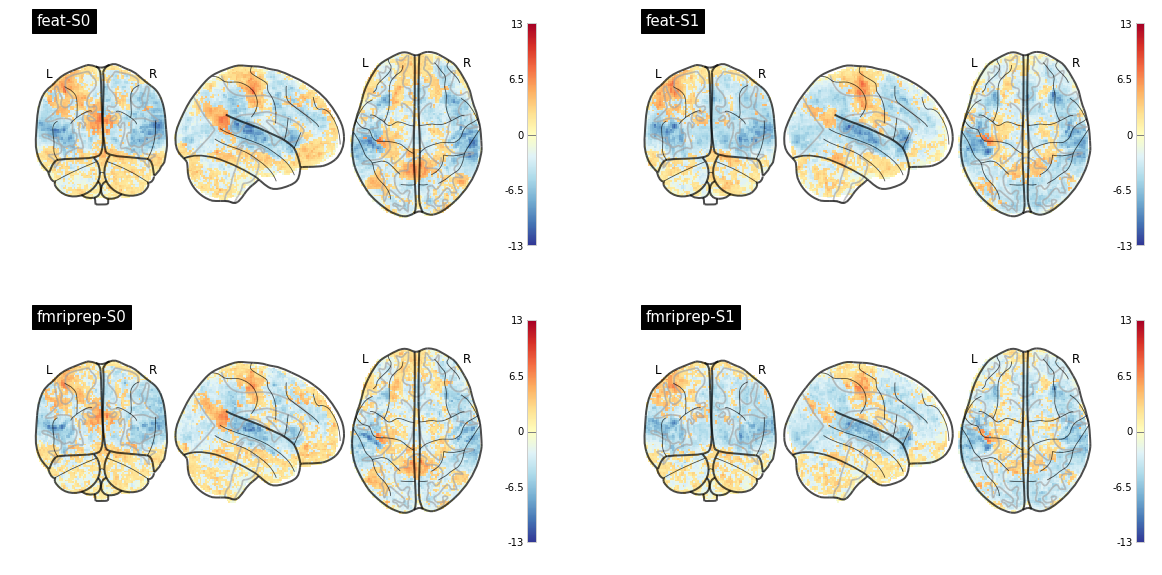

In [47]:
plt.clf()
fig = plt.figure(figsize=(20,10))
plotting.plot_glass_brain(str(group_dir / 'fslfeat_stopsignal_N050_R100_S0' / 'tstat1.nii.gz'),
                          title='feat-S0',cmap='RdYlBu_r',
                          vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False,
                          axes=plt.subplot(2, 2, 1))
plotting.plot_glass_brain(str(group_dir / 'fslfeat_stopsignal_N050_R100_S1' / 'tstat1.nii.gz'),
                          title='feat-S1',cmap='RdYlBu_r',
                          vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False,
                          axes=plt.subplot(2, 2, 2))

plotting.plot_glass_brain(str(group_dir / 'fmriprep_stopsignal_N050_R100_S0' / 'tstat1.nii.gz'),
                          title='fmriprep-S0',cmap='RdYlBu_r',
                          vmax = 13, colorbar=True, symmetric_cbar=True, plot_abs=False,
                          axes=plt.subplot(2, 2, 3))
plotting.plot_glass_brain(str(group_dir / 'fmriprep_stopsignal_N050_R100_S1' / 'tstat1.nii.gz'),
                          title='fmriprep-S1', cmap='RdYlBu_r',
                          vmax = 13, colorbar=True, symmetric_cbar=True, plot_abs=False,
                          axes=plt.subplot(2, 2, 4))

## 3.3. Agreement between group activations

In [37]:
dataframe = pd.read_csv(group_dir / 'group.csv', index_col=0)
dataframe.columns = ['IFG', 'N', 'PCG', 'STN', 'correlation', 'bdiceall', 'bdice', 'fdiceall',
       'fdice', 'pipeline', 'preSMA', 'repetition']
dataframe.N = dataframe.N.astype(int)

Text(0.5,0,'Sample size $N$')

<Figure size 432x288 with 0 Axes>

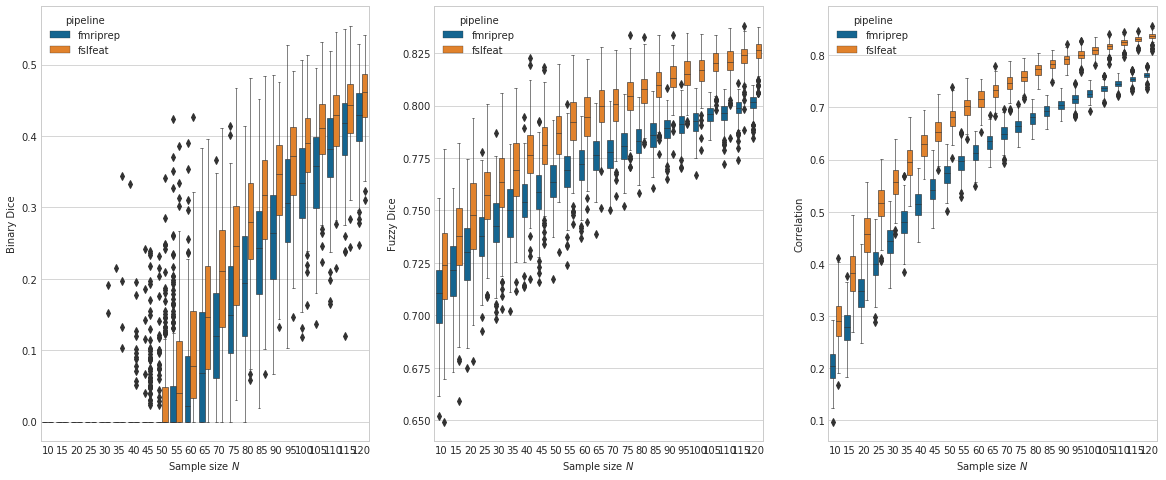

In [38]:
cols = palettable.tableau.ColorBlind_10.hex_colors
sn.set_style("whitegrid")

plt.clf()
fig = plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sn.boxplot(x="N", y="bdice", hue='pipeline', hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=0.6)

plt.ylabel("Binary Dice")
plt.xlabel("Sample size $N$")

plt.subplot(1,3,2)
sn.boxplot(x="N", y="fdice", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
plt.ylabel("Fuzzy Dice")
plt.xlabel("Sample size $N$")
plt.subplot(1,3,3)
sn.boxplot(x="N", y="correlation", hue="pipeline", hue_order=['fmriprep', 'fslfeat'],
           data=dataframe, palette=cols, linewidth=.6)
plt.ylabel("Correlation")
plt.xlabel("Sample size $N$")

## 3.4. Atlases and effect sizes in regions
Below we show how we analyse the effect size in our regions of interest. The regions of interest are:

  * Purple: the Subthalamic Nucleus (STN)
  * Yellow: the Inferior Frontal Gyrus (IFG)
  * Blue: the pre-Supplementary Motor Area (preSMA)
  * Red: the Precentral Gyrus (PCG)

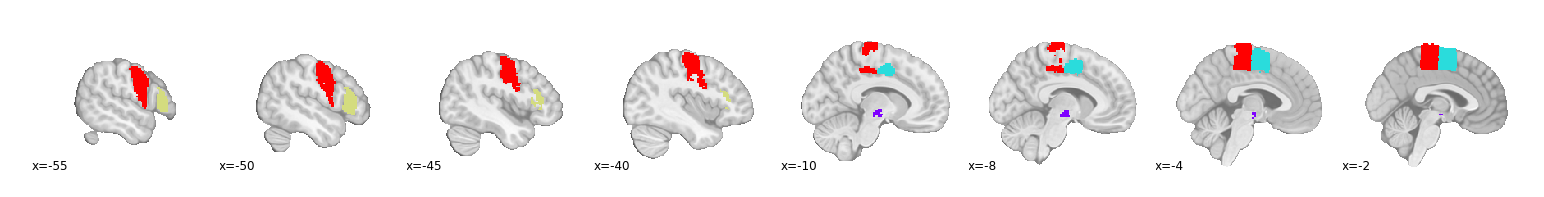

In [40]:
ATLAS_HOME = DERIVS_HOME / 'fmriprep_vs_feat_2.0-jd'

atlas_data = nb.load(str(ATLAS_HOME / 'l2-jd' / '2mm_atlas_rois.nii.gz')).get_data()
labels = {1: 'STN', 2: 'preSMA', 3: 'IFG', 4: 'PCG'}

cut_coords = [-2,-4,-8,-10,-40,-45,-50,-55]
plotting.plot_roi(str(ATLAS_HOME / 'l2-jd' / '2mm_atlas_rois.nii.gz'),
                  display_mode='x', cut_coords=cut_coords, 
                  cmap='rainbow', alpha=1, bg_img=atlas)

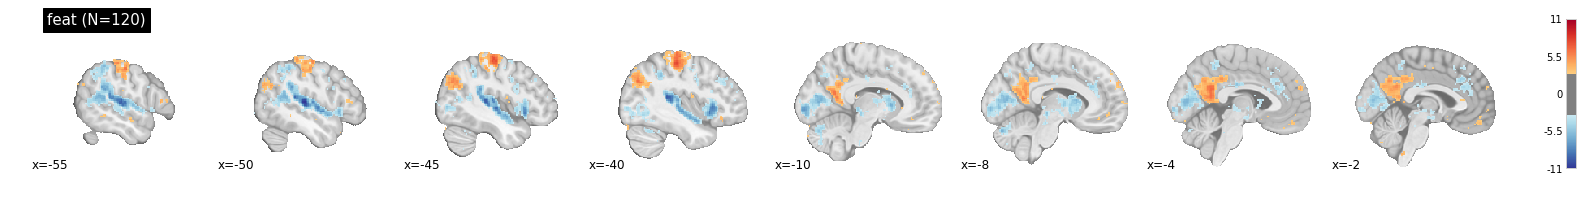

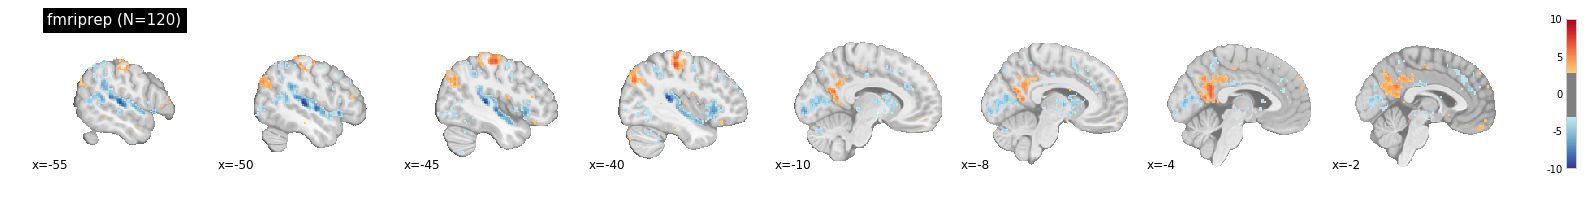

In [41]:
cut_coords = [-2,-4,-8,-10,-40,-45,-50,-55]
plotting.plot_stat_map(str(group_dir / 'fslfeat_stopsignal_N120_R100_S0' / 'zstat1.nii.gz'),
                       display_mode='x', cut_coords=cut_coords, cmap='RdYlBu_r',
                       alpha=1, threshold=2.98, title='feat (N=120)', bg_img=atlas)
plotting.plot_stat_map(str(group_dir / 'fmriprep_stopsignal_N120_R100_S0' / 'zstat1.nii.gz'),
                       display_mode='x', cut_coords=cut_coords, cmap='RdYlBu_r',
                       alpha=1, threshold=2.98, title='fmriprep (N=120)', bg_img=atlas)

### Effect sizes
Below is a table with the effect sizes estimates for this particular example. We will repeat this analysis for all experiments below.

In [42]:
samplesize = 120
feat_zs = nb.load(str(group_dir / ('fslfeat_stopsignal_N%03d_R100_S0' % samplesize) /
                      'zstat1.nii.gz')).get_data()
fmriprep_zs = nb.load(str(group_dir / ('fmriprep_stopsignal_N%03d_R100_S0' % samplesize) /
                          'zstat1.nii.gz')).get_data()

sqrtN = np.sqrt(samplesize)
zs_rois = {'feat': {},
           'fmriprep': {}}
for k, v in labels.items():
    zs_rois['feat'][v] = np.mean(feat_zs[atlas_data == k]) / sqrtN
    zs_rois['fmriprep'][v] = np.mean(fmriprep_zs[atlas_data == k]) / sqrtN
    
pd.DataFrame(zs_rois)[['fmriprep', 'feat']]

,fmriprep,feat
IFG,-0.060067,-0.070148
PCG,-0.013095,0.004173
STN,-0.121256,-0.173566
preSMA,-0.026691,-0.038749


# Test-retest replicability for different sample sizes

We can now take a look at the distribution of effect sizes in all experiment (100 x 2 samples = 200 group studies). Note though that the studies **are not** independent and reflect activation from the same 257 subjects.

In [43]:
import json

results = pd.read_csv(str(group_dir / "group.csv"), index_col=0)[
    ['N', 'pipeline', 'IFG', 'PCG', 'STN', 'preSMA', 'repetition']]
results.N = results.N.astype(int)
results.repetition = results.repetition.astype(int)

with open(str(group_dir / "tvals.json")) as json_data:
    allT = json.load(json_data)
    json_data.close()

In [44]:
results.head()

,N,pipeline,IFG,PCG,STN,preSMA,repetition
0,10,fmriprep,-0.047212,-0.077533,-0.173196,-0.119033,1
1,10,fmriprep,-0.158526,0.040736,-0.160207,0.021814,2
2,10,fmriprep,-0.002967,0.010578,-0.166713,-0.023503,3
3,10,fmriprep,-0.196887,-0.031437,-0.194041,-0.028481,4
4,10,fmriprep,0.015045,0.019981,-0.017000,0.118241,5


<Figure size 432x288 with 0 Axes>

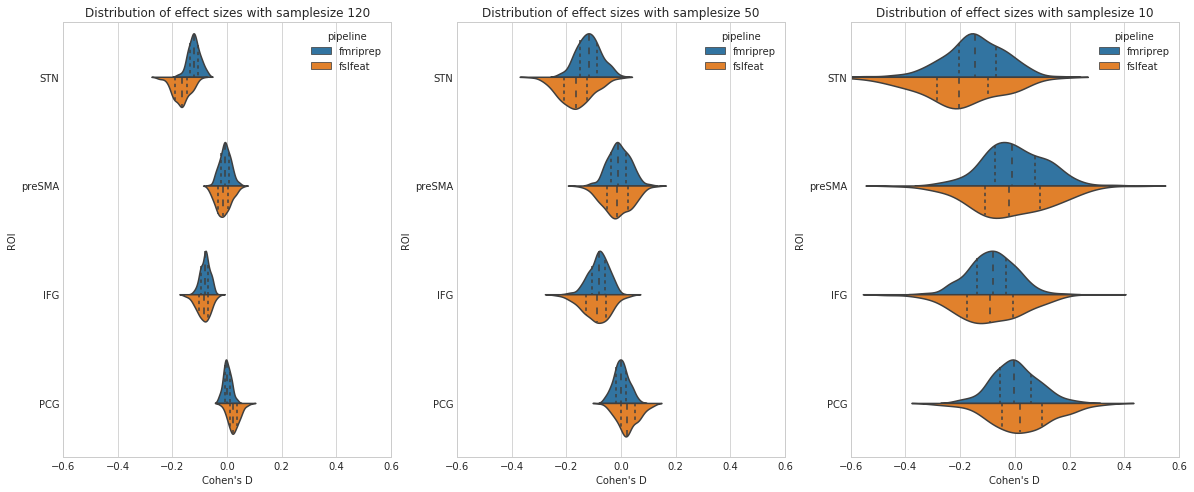

In [45]:
sn.set_style("whitegrid")

plt.clf()
fig = plt.figure(figsize=(20,8))

xlim=[-0.6,0.6]

reslong = pd.melt(results, id_vars=['pipeline','N'],
                  value_vars=labels.values(), var_name="ROI", value_name="Cohen's D")

plt.subplot(1, 3, 1)
samplesize = 120
sn.violinplot(x="Cohen's D", y='ROI', hue='pipeline', 
              data=reslong[reslong.N==samplesize],
              split=True, inner='quartile')
plt.title("Distribution of effect sizes with samplesize %d" % samplesize)
plt.xlim(xlim)

plt.subplot(1, 3, 2)
samplesize = 50
sn.violinplot(x="Cohen's D", y='ROI', hue='pipeline', 
              data=reslong[reslong.N==samplesize],
              split=True, inner='quartile')
plt.title("Distribution of effect sizes with samplesize %d" % samplesize)
plt.xlim(xlim)

plt.subplot(1, 3, 3)
samplesize = 10
sn.violinplot(x="Cohen's D", y='ROI', hue='pipeline', 
              data=reslong[reslong.N==samplesize],
              split=True, inner='quartile')
plt.title("Distribution of effect sizes with samplesize %d" % samplesize)
plt.xlim(xlim);